# Sleep Pattern Prediction - Training LSTM

##  Loading Libraries

In [1]:
import numpy as np
from sklearn.metrics import classification_report
#from utils import gen, chunker, WINDOW_SIZE, rescale_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, classification_report
from glob import glob
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
#tf.keras.optimizers.Adam(learning_rate)
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
    

## Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from numpy import load

In [4]:
x_train = load('/content/drive/MyDrive/Iot/x_train.npy')
y_train = load('/content/drive/MyDrive/Iot/y_train.npy')
x_val = load('/content/drive/MyDrive/Iot/x_val.npy')
y_val = load('/content/drive/MyDrive/Iot/y_val.npy')
x_test = load('/content/drive/MyDrive/Iot/x_test.npy')
y_test = load('/content/drive/MyDrive/Iot/y_test.npy')

## LSTM Model

In [5]:
def get_base_model():
    inp = Input(shape=(3000, 1))
    img_1 = Convolution1D(16, kernel_size=10, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=10, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=3)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    #img_1 = Convolution1D(64, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    #img_1 = Convolution1D(64, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    #img_1 = MaxPool1D(pool_size=2)(img_1)
    #img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(128, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(128, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)

    dense_1 = Dropout(0.01)(Dense(64, activation = 'sigmoid', name="dense_1")(img_1))

    base_model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #model.summary()
    return base_model
def get_model_lstm():
    nclass = 5

    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    #for layer in base_model.layers:
        #layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.1)(encoded_sequence)
    #encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.07)(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=1, activation="sigmoid", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [6]:
x_train_unsqueeze=x_train.reshape(x_train.shape[0],1,3000,1)
x_val_unsqueeze=x_val.reshape(x_val.shape[0],1,3000,1)

In [7]:
lstm_model=get_model_lstm()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 3000, 1)]   0         
                                                                 
 time_distributed (TimeDistr  (None, None, 64)         80448     
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        132000    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, None, 200)         0         
                                                                 
 dropout_3 (Dropout)         (None, None, 200)         0         
                                                                 
 conv1d_6 (Conv1D)           (None, None, 5)           1005

In [8]:
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = lstm_model.fit(x_train_unsqueeze, y_train, batch_size = 128, 
                    epochs = 500, validation_data =(x_val_unsqueeze, y_val), 
                    callbacks =[earlystopping])

Epoch 1/500
725/725 [==============================] - 92s 79ms/step - loss: 1.2718 - acc: 0.2021 - val_loss: 0.9903 - val_acc: 0.2026
Epoch 2/500
725/725 [==============================] - 56s 77ms/step - loss: 0.9454 - acc: 0.2032 - val_loss: 0.8875 - val_acc: 0.2030
Epoch 3/500
725/725 [==============================] - 56s 77ms/step - loss: 0.8589 - acc: 0.2033 - val_loss: 0.8104 - val_acc: 0.2033
Epoch 4/500
725/725 [==============================] - 56s 78ms/step - loss: 0.8139 - acc: 0.2038 - val_loss: 0.8135 - val_acc: 0.2034
Epoch 5/500
725/725 [==============================] - 56s 78ms/step - loss: 0.7828 - acc: 0.2037 - val_loss: 0.7377 - val_acc: 0.2035
Epoch 6/500
725/725 [==============================] - 56s 78ms/step - loss: 0.7524 - acc: 0.2037 - val_loss: 0.7144 - val_acc: 0.2033
Epoch 7/500
725/725 [==============================] - 56s 77ms/step - loss: 0.7343 - acc: 0.2041 - val_loss: 0.6958 - val_acc: 0.2035
Epoch 8/500
725/725 [==============================] - 

In [10]:
import matplotlib.pyplot as plt

### Summarize history for accuracy

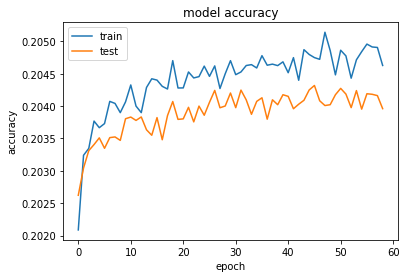

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Summarize history for loss

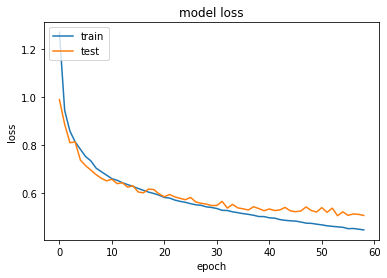

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Saving Model

In [13]:
lstm_model.save('/content/drive/MyDrive/Iot/lstm.h5')

## Testing

### Testing on Training Data

In [14]:
y_pred_train = lstm_model.predict(x_train_unsqueeze)
y_pred_train = y_pred_train.argmax(axis=-1).ravel().tolist()

In [15]:
report = classification_report(y_train, y_pred_train)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     18548
           1       0.73      0.76      0.75     18547
           2       0.82      0.78      0.80     18547
           3       0.93      0.94      0.94     18547
           4       0.80      0.80      0.80     18547

    accuracy                           0.84     92736
   macro avg       0.84      0.84      0.84     92736
weighted avg       0.84      0.84      0.84     92736



### Testing on Testing Data

In [16]:
x_test_unsqueeze=x_test.reshape(x_test.shape[0],1,3000,1)

In [17]:
y_pred_test = lstm_model.predict(x_test_unsqueeze)
y_pred_test = y_pred_test.argmax(axis=-1).ravel().tolist()

In [18]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2289
           1       0.67      0.70      0.68      2290
           2       0.75      0.73      0.74      2290
           3       0.91      0.92      0.92      2290
           4       0.75      0.73      0.74      2290

    accuracy                           0.79     11449
   macro avg       0.79      0.79      0.79     11449
weighted avg       0.79      0.79      0.79     11449

